## BFCL

In [1]:
from unsloth import FastLanguageModel
import torch
model_name = "unsloth/Llama-3.2-1B-Instruct"
dtype = torch.bfloat16
load_in_4bit = False
model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=model_name,  # or choose "unsloth/Llama-3.2-1B"
        # max_seq_length = max_seq_length,
        dtype=dtype,
        load_in_4bit=load_in_4bit,
        trust_remote_code=True,
    )

/home/recoverx/.cache/pypoetry/virtualenvs/finetuning-KL8mpKMW-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/recoverx/.cache/pypoetry/virtualenvs/finetuning-KL8mpKMW-py3.10/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2024.10.7: Fast Llama patching. Transformers = 4.46.1.
   \\   /|    GPU: NVIDIA A100 80GB PCIe. Max memory: 79.325 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


In [2]:
import json
from datasets import Dataset
import functools
import finetune

train_data = []
with open("train.json", "r") as file:
    for line in file:
        json_obj = json.loads(line.strip())
        json_obj["Functions"] = (
            json_obj["Functions"][0]
            if isinstance(json_obj["Functions"], list)
            else json_obj["Functions"]
        )
        json_obj["Output"] = (
            json_obj["Output"][0]
            if isinstance(json_obj["Output"], list)
            else json_obj["Output"]
        )
        train_data.append(json_obj)

with open("test.json", "r") as file:
    test_data = json.load(file)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: athe_kunal (ad-finance). Use `wandb login --relogin` to force relogin


In [3]:
def get_bfcl_ds(json_or_yaml)->tuple[list[int],list[int]]:
    train_ds = Dataset.from_list(train_data)
    train_ds = train_ds.map(
        functools.partial(
            finetune._get_bfcl_train_tokenized_ds,
            tokenizer=tokenizer,
            json_or_yaml=json_or_yaml,
        ),
        batched=True,
    )
    test_ds = Dataset.from_list(test_data)
    test_ds = test_ds.map(
        functools.partial(
            finetune._get_bfcl_tokenized_test_ds,
            tokenizer=tokenizer,
            json_or_yaml=json_or_yaml,
        ),
        batched=True,
        remove_columns=["function", "question"],
    )
    num_train_tokens, num_test_tokens = get_token_length(train_ds, tokenizer), get_token_length(test_ds, tokenizer)
    return num_train_tokens, num_test_tokens

def get_token_length(ds,tokenizer):
    tokens = tokenizer(ds['prompt'])
    return [len(token) for token in tokens['input_ids']]

In [4]:
num_train_tokens_json_bfcl, num_test_tokens_json_bfcl = get_bfcl_ds("json")
num_train_tokens_yaml_bfcl, num_test_tokens_yaml_bfcl = get_bfcl_ds("yaml")

Map: 100%|██████████| 112/112 [00:00<00:00, 137.16 examples/s]


In [5]:
from scipy import stats
import numpy as np

def compare_token_lengths(tokens_json, tokens_yaml):
    # Perform independent t-test
    t_stat, p_value = stats.ttest_ind(tokens_json, tokens_yaml)

    print("Statistical comparison of JSON vs YAML token lengths:")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")

    # Calculate and print means
    json_mean = np.mean(tokens_json)
    yaml_mean = np.mean(tokens_yaml)
    print(f"\nMean token length:")
    print(f"JSON: {json_mean:.2f}")
    print(f"YAML: {yaml_mean:.2f}")
    print(f"Difference (JSON - YAML): {json_mean - yaml_mean:.2f}")
    print(f"p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("\nThe difference is statistically significant (p < 0.05)")
        print(f"{'JSON' if json_mean > yaml_mean else 'YAML'} has significantly longer token lengths")
    else:
        print("\nThe difference is not statistically significant (p >= 0.05)")


## XLAM

In [6]:
from datasets import DatasetDict


def get_xlam_ds(json_or_yaml)->tuple[Dataset,Dataset]:
    ds = DatasetDict.load_from_disk(f"xlam_data_{json_or_yaml}")['train']
    split_ds = ds.train_test_split(test_size=1000,seed=42)
    train_ds = split_ds['train']
    test_ds = split_ds['test']
    return train_ds, test_ds

train_ds, test_ds = get_xlam_ds("json")
num_train_tokens_json_xlam, num_test_tokens_json_xlam = get_token_length(train_ds, tokenizer), get_token_length(test_ds, tokenizer)

In [7]:
train_ds_yaml, test_ds_yaml = get_xlam_ds("yaml")
num_train_tokens_yaml_xlam, num_test_tokens_yaml_xlam = get_token_length(train_ds_yaml, tokenizer), get_token_length(test_ds_yaml, tokenizer)

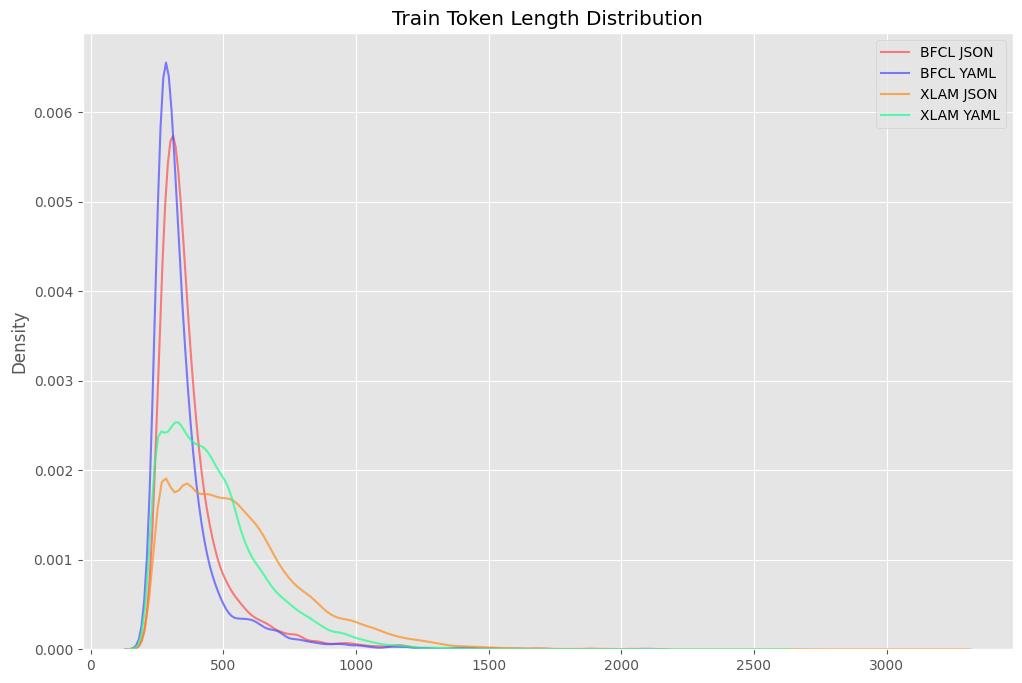

In [21]:
#plot num_train_tokens_json, num_train_tokens_yaml as a normal distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
sns.kdeplot(data=num_train_tokens_json_bfcl, alpha=0.7, label='BFCL JSON', color='#FF4B4B')
sns.kdeplot(data=num_train_tokens_yaml_bfcl, alpha=0.7, label='BFCL YAML', color='#4B4BFF') 
sns.kdeplot(data=num_train_tokens_json_xlam, alpha=0.7, label='XLAM JSON', color='#FF8C1A')
sns.kdeplot(data=num_train_tokens_yaml_xlam, alpha=0.7, label='XLAM YAML', color='#1AFF8C')
plt.legend(loc='upper right')
plt.title('Train Token Length Distribution')
plt.show()

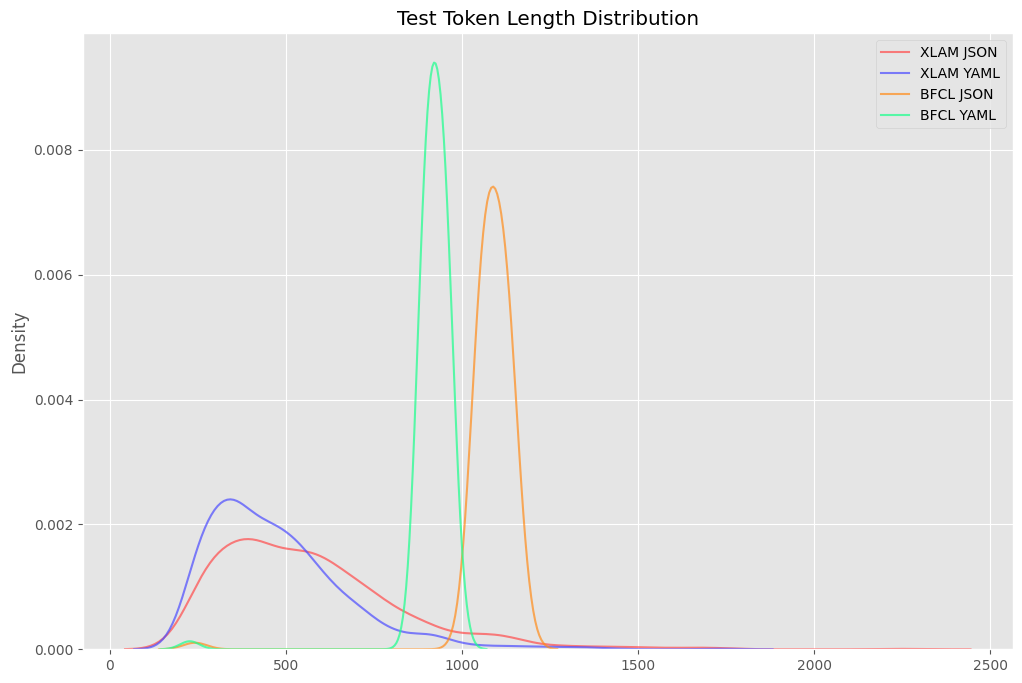

In [22]:
#plot num_train_tokens_json, num_train_tokens_yaml as a normal distribution
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
sns.kdeplot(data=num_test_tokens_json_xlam, alpha=0.7, label='XLAM JSON', color='#FF4B4B')
sns.kdeplot(data=num_test_tokens_yaml_xlam, alpha=0.7, label='XLAM YAML', color='#4B4BFF')
sns.kdeplot(data=num_test_tokens_json_bfcl, alpha=0.7, label='BFCL JSON', color='#FF8C1A') 
sns.kdeplot(data=num_test_tokens_yaml_bfcl, alpha=0.7, label='BFCL YAML', color='#1AFF8C')
plt.legend(loc='upper right')
plt.title('Test Token Length Distribution')
plt.show()

In [12]:
def compare_token_lengths(tokens_json, tokens_yaml):
    # Compare the percentage difference between the two distributions
    percentage_difference_json = (np.mean(tokens_json) - np.mean(tokens_yaml)) / np.mean(tokens_json) * 100
    percentage_difference_yaml = (np.mean(tokens_yaml) - np.mean(tokens_json)) / np.mean(tokens_yaml) * 100
    print(f"Percentage difference between JSON and YAML: {percentage_difference_json:.2f}%")
    print(f"Percentage difference between YAML and JSON: {percentage_difference_yaml:.2f}%")

compare_token_lengths(num_train_tokens_json_xlam, num_train_tokens_yaml_xlam)


Percentage difference between JSON and YAML: 15.80%
Percentage difference between YAML and JSON: -18.77%


In [13]:
compare_token_lengths(num_test_tokens_json_xlam, num_test_tokens_yaml_xlam)

Percentage difference between JSON and YAML: 16.04%
Percentage difference between YAML and JSON: -19.10%


In [14]:
compare_token_lengths(num_test_tokens_json_bfcl, num_test_tokens_yaml_bfcl)

Percentage difference between JSON and YAML: 15.31%
Percentage difference between YAML and JSON: -18.08%


In [15]:
compare_token_lengths(num_train_tokens_json_bfcl, num_train_tokens_yaml_bfcl)

Percentage difference between JSON and YAML: 7.44%
Percentage difference between YAML and JSON: -8.04%


In [24]:
XLAM_TRAIN_DIFF = 15.80
XLAM_TEST_DIFF = 16.04
BFCL_TRAIN_DIFF = 7.44
BFCL_TEST_DIFF = 15.31

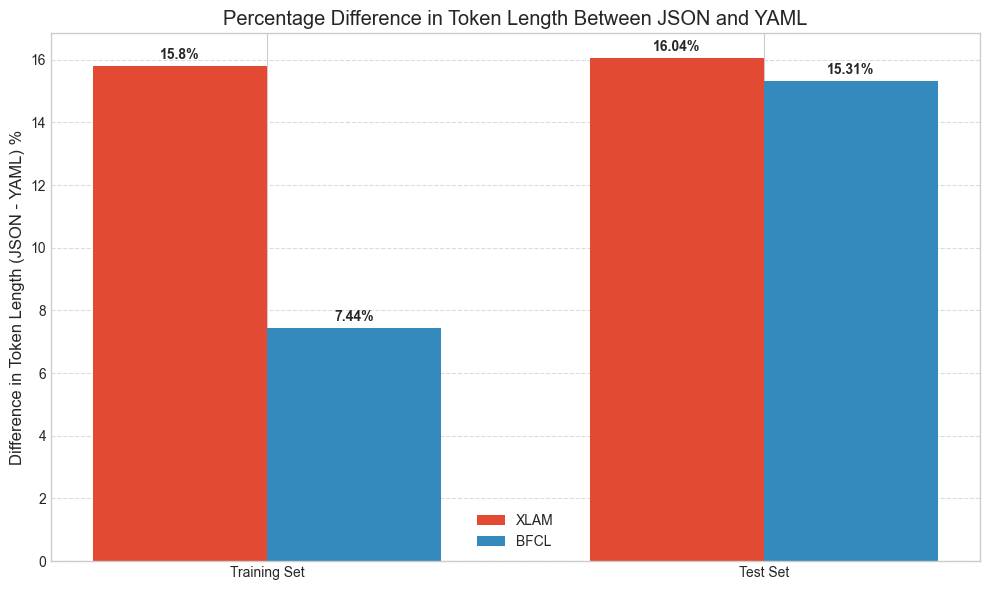

In [32]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use( 'seaborn-v0_8-whitegrid')

# Data
labels = ['Training Set', 'Test Set']
xlam_values = [15.80, 16.04]
bfcl_values = [7.44, 15.31]

# Set up bar positions
x = np.arange(len(labels))
width = 0.35

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, xlam_values, width, label='XLAM')  # Standard scientific blue
rects2 = ax.bar(x + width/2, bfcl_values, width, label='BFCL')  # Standard scientific orange

# Customize plot
ax.set_ylabel('Difference in Token Length (JSON - YAML) %')
ax.set_title('Percentage Difference in Token Length Between JSON and YAML')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', weight='bold')

autolabel(rects1)
autolabel(rects2)

# Add grid for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [2]:
XLAM_DICT = {
    "JSON":{
        "8B": {"EPOCH 1": 0.688, "EPOCH 2": 0.634, "EPOCH 3": 0.633},
        "1B": {"EPOCH 1": 0.65, "EPOCH 2": 0.58, "EPOCH 3": 0.55},
        "3B": {"EPOCH 1": 0.732, "EPOCH 2": 0.515, "EPOCH 3": 0.645}
    },
    "YAML":{
        "8B": {"EPOCH 1": 0.726, "EPOCH 2": 0.685, "EPOCH 3": 0.688},
        "1B": {"EPOCH 1": 0.443, "EPOCH 2": 0.56, "EPOCH 3": 0.486},
        "3B": {"EPOCH 1": 0.59, "EPOCH 2": 0.45, "EPOCH 3": 0.526}
    }
}

In [3]:
BFCL_DICT = {
    "JSON":{
        "8B": {"EPOCH 1": 0.595, "EPOCH 2": 0.553, "EPOCH 3": 0.551},
        "1B": {"EPOCH 1": 0.522, "EPOCH 2": 0.512, "EPOCH 3": 0.482},
        "3B": {"EPOCH 1": 0.609, "EPOCH 2": 0.610, "EPOCH 3": 0.591}
    },
    "YAML":{
        "8B": {"EPOCH 1": 0.57, "EPOCH 2": 0.56, "EPOCH 3": 0.55},
        "1B": {"EPOCH 1": 0.511, "EPOCH 2": 0.487, "EPOCH 3": 0.501},
        "3B": {"EPOCH 1": 0.617, "EPOCH 2": 0.620, "EPOCH 3": 0.619}
    }
}

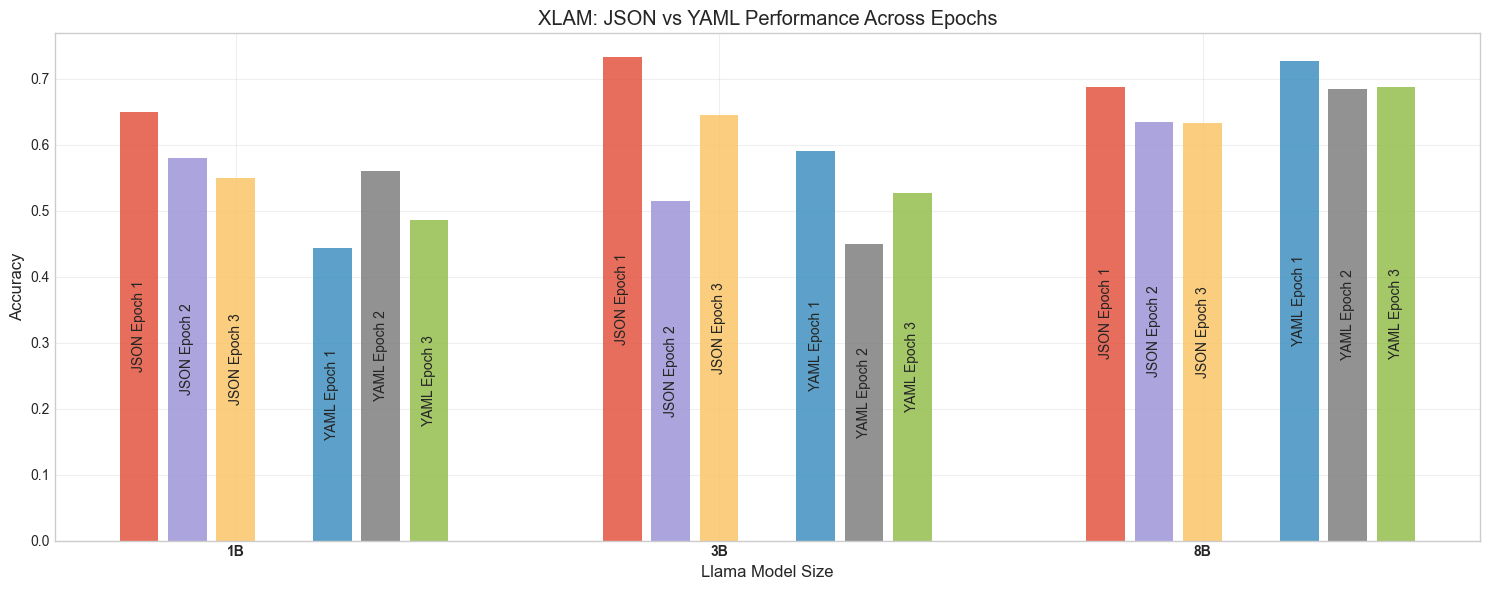

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure size
plt.figure(figsize=(15, 6))
# plt.style.use('ggplot')
plt.style.use( 'seaborn-v0_8-whitegrid')

# Define positions for bars
model_sizes = ['1B', '3B', '8B']
x = np.arange(len(model_sizes))
width = 0.1  # Reduced width of bars

# Plot bars for each epoch
for i, epoch in enumerate(['EPOCH 1', 'EPOCH 2', 'EPOCH 3']):
    # JSON bars
    json_scores = [XLAM_DICT['JSON'][size][epoch] for size in model_sizes]
    bars_json = plt.bar(x - width*2 + (i*width), json_scores, width*0.8, 
            label=f'JSON', alpha=0.8)
    
    # YAML bars  
    yaml_scores = [XLAM_DICT['YAML'][size][epoch] for size in model_sizes]
    bars_yaml = plt.bar(x + width*2 + (i*width), yaml_scores, width*0.8,
            label=f'YAML', alpha=0.8)
    
    # Add epoch labels inside bars
    for idx, (json_score, yaml_score) in enumerate(zip(json_scores, yaml_scores)):
        plt.text(x[idx] - width*2 + (i*width), json_score/2, f'JSON Epoch {i+1}',
                ha='center', va='center', rotation=90)
        plt.text(x[idx] + width*2 + (i*width), yaml_score/2, f'YAML Epoch {i+1}',
                ha='center', va='center', rotation=90)

# Customize plot
plt.xlabel('Llama Model Size')
plt.ylabel('Accuracy')
plt.title('XLAM: JSON vs YAML Performance Across Epochs')
plt.xticks(x, model_sizes, weight='bold')
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

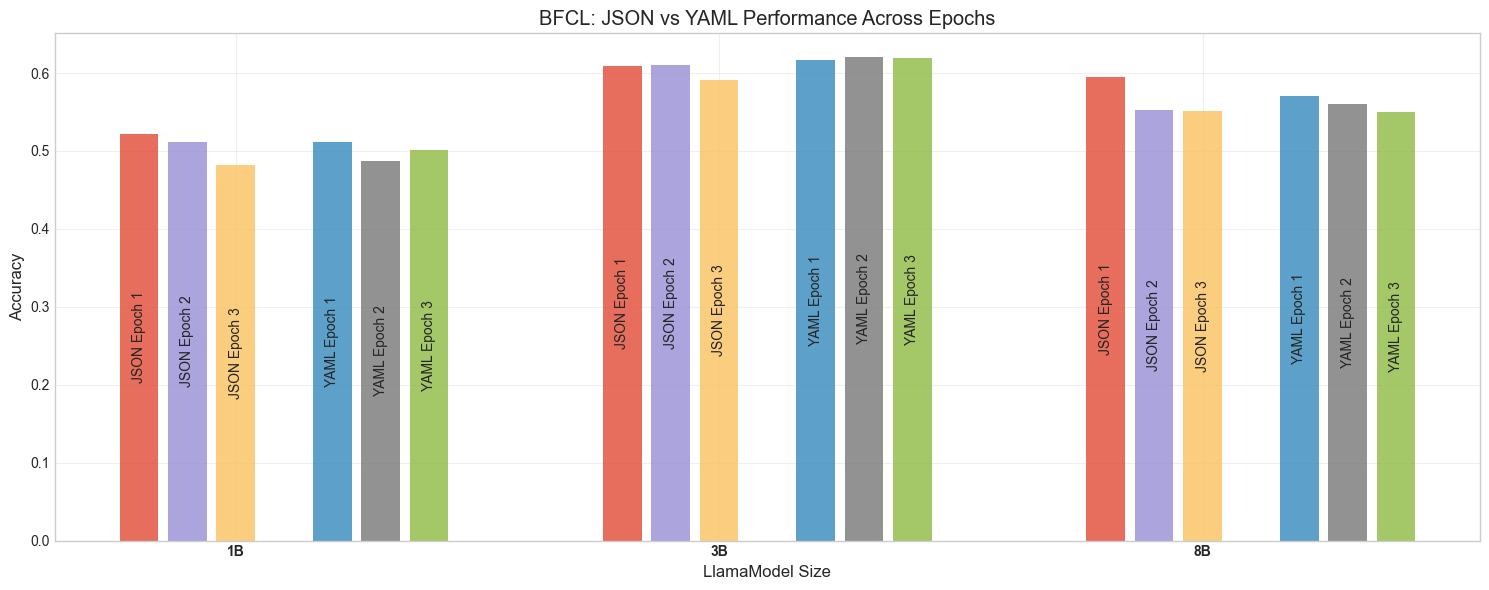

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure size
plt.figure(figsize=(15, 6))
# plt.style.use('ggplot')
plt.style.use( 'seaborn-v0_8-whitegrid')

# Define positions for bars
model_sizes = ['1B', '3B', '8B']
x = np.arange(len(model_sizes))
width = 0.1  # Reduced width of bars

# Plot bars for each epoch
for i, epoch in enumerate(['EPOCH 1', 'EPOCH 2', 'EPOCH 3']):
    # JSON bars
    json_scores = [BFCL_DICT['JSON'][size][epoch] for size in model_sizes]
    bars_json = plt.bar(x - width*2 + (i*width), json_scores, width*0.8, 
            label=f'JSON', alpha=0.8)
    
    # YAML bars  
    yaml_scores = [BFCL_DICT['YAML'][size][epoch] for size in model_sizes]
    bars_yaml = plt.bar(x + width*2 + (i*width), yaml_scores, width*0.8,
            label=f'YAML', alpha=0.8)
    
    # Add epoch labels inside bars
    for idx, (json_score, yaml_score) in enumerate(zip(json_scores, yaml_scores)):
        plt.text(x[idx] - width*2 + (i*width), json_score/2, f'JSON Epoch {i+1}',
                ha='center', va='center', rotation=90)
        plt.text(x[idx] + width*2 + (i*width), yaml_score/2, f'YAML Epoch {i+1}',
                ha='center', va='center', rotation=90)

# Customize plot
plt.xlabel('LlamaModel Size')
plt.ylabel('Accuracy')
plt.title('BFCL: JSON vs YAML Performance Across Epochs')
plt.xticks(x, model_sizes, weight='bold')
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()